# YOLOv8 vs YOLOv12 Comparison

Compare performance metrics, training time, parameters, and inference speed.


In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

project_root = Path('..').resolve() if Path.cwd().name == 'notebooks' else Path('.')
models_dir = project_root / 'models'

# Load metrics
with open(models_dir / 'yolov8_metrics.json') as f:
    v8_metrics = json.load(f)
with open(models_dir / 'yolov12_metrics.json') as f:
    v12_metrics = json.load(f)

print("✓ Metrics loaded")

✓ Metrics loaded


## Step 1: Create Comparison DataFrame

Organize all metrics in a clean table format.


In [3]:
df = pd.DataFrame({
    'Model': ['YOLOv8n', 'YOLOv12n'],
    'Training (s)': [v8_metrics['training_time'], v12_metrics['training_time']],
    'Params (M)': [v8_metrics['params'], v12_metrics['params']],
    'Inference (ms)': [v8_metrics['inference_time_ms'], v12_metrics['inference_time_ms']],
    'mAP@50': [v8_metrics['map50'], v12_metrics['map50']],
    'mAP@50-95': [v8_metrics['map50_95'], v12_metrics['map50_95']]
})

print("\nComparison Table:")
print("="*80)
print(df.to_string(index=False))
print("="*80)


Comparison Table:
   Model  Training (s)  Params (M)  Inference (ms)   mAP@50  mAP@50-95
 YOLOv8n     16.669111    3.011628       65.565704 0.000000   0.000000
YOLOv12n     36.352881    2.520444      130.519338 0.000199   0.000039


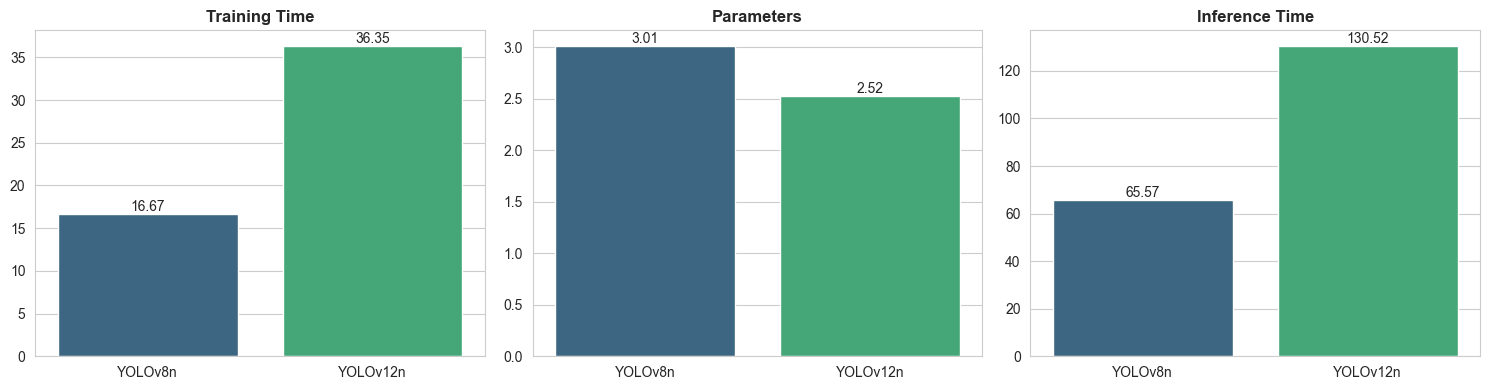

✓ Resource comparison complete


In [5]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col, title in zip(axes, ['Training (s)', 'Params (M)', 'Inference (ms)'],
                           ['Training Time', 'Parameters', 'Inference Time']):
    sns.barplot(x='Model', y=col, data=df, hue='Model', ax=ax, palette='viridis', legend=False)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('')
    ax.set_xlabel('')
    for i, v in enumerate(df[col]):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
print("✓ Resource comparison complete")

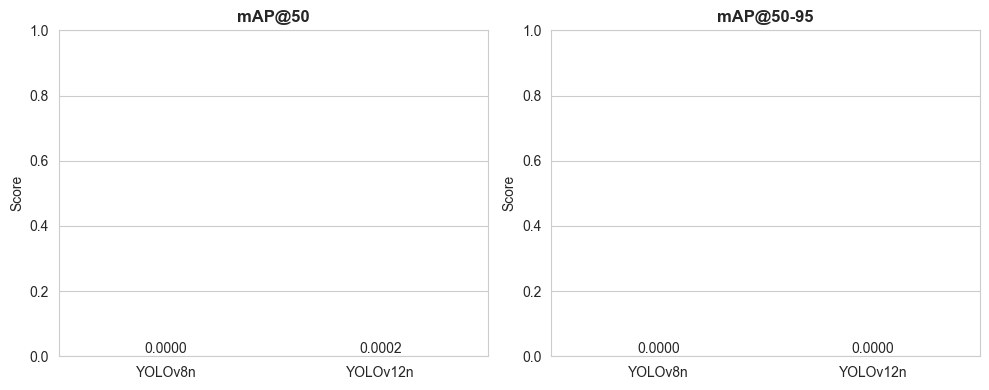

✓ Accuracy comparison complete


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, col, title in zip(axes, ['mAP@50', 'mAP@50-95'], ['mAP@50', 'mAP@50-95']):
    sns.barplot(x='Model', y=col, data=df, hue='Model', ax=ax, palette='magma', legend=False)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_xlabel('')
    ax.set_ylim(0, 1)
    for i, v in enumerate(df[col]):
        ax.text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
print("✓ Accuracy comparison complete")

In [7]:
best_idx = df['mAP@50-95'].idxmax()
best_model = df.loc[best_idx, 'Model']

print(f"\n{'='*60}")
print(f"RECOMMENDED MODEL: {best_model}")
print(f"{'='*60}")
print(df.loc[best_idx].to_string())
print(f"{'='*60}")


RECOMMENDED MODEL: YOLOv12n
Model               YOLOv12n
Training (s)       36.352881
Params (M)          2.520444
Inference (ms)    130.519338
mAP@50              0.000199
mAP@50-95           0.000039
